# Analysis of matrices

Herman Kamper, 2024-2025

In [3]:
from datetime import datetime
from matplotlib.ticker import FormatStrFormatter
from numpy import linalg
from pathlib import Path
from tqdm.notebook import tqdm
import celer
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torchaudio

sys.path.append("..")

from utils import fast_cosine_dist, pca_transform, pca_inverse_transform

In [ ]:
device = "cuda"

## Utilities

In [3]:
n_fft = 256
n_overlap = 128
sr = 16000
pad_xextent = (n_fft - n_overlap)/sr/2

def specgram(x, sr):
    """
    Return the spectrogram array and extent.
    
    Based on:
    <https://stackoverflow.com/questions/53385242/matplotlib-spectrogram-animation-without-calling-pyplot-specgram-directly-every>
    """
    spec, freqs, t = plt.mlab.specgram(x, Fs=sr)
    x_min = np.min(t) - pad_xextent
    x_max = np.max(t) + pad_xextent
    extent = x_min, x_max, freqs[0], freqs[-1]
    arr = np.flipud(10*np.log10(spec))
    return arr, extent

## Models

In [5]:
wavlm = torch.hub.load("bshall/knn-vc", "wavlm_large", trust_repo=True, device=device)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master
/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WavLM-Large loaded with 315,453,120 parameters.


In [5]:
hifigan, _ = torch.hub.load("bshall/knn-vc", "hifigan_wavlm", trust_repo=True, device=device, prematched=True)

Removing weight norm...
[HiFiGAN] Generator loaded with 16,523,393 parameters.


Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master


## LinearVC

In [ ]:
features_dir = Path("/home/kamperh/scratch/vctk/wavlm/")
wav_dir = Path("/home/kamperh/scratch/vctk/wav/")
# source = "p279"
source = "p225"
# target = "p282"
target = "p287"

In [ ]:
source_feats_all = np.load((features_dir / source).with_suffix(".npy"))
target_feats_all = np.load((features_dir / target).with_suffix(".npy"))

In [ ]:
k_top = 1
n_frames = 8192

source_feats = torch.from_numpy(source_feats_all[:n_frames, :]).float().to(device)
target_feats = torch.from_numpy(target_feats_all[:n_frames, :]).float().to(device)

print(datetime.now())
print("Matching")

dists = fast_cosine_dist(
    source_feats.squeeze(), target_feats, device=device
)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

print(datetime.now())
print("Regression")
b = None

# Normal
# W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

# Lasso
linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
    source_feats.squeeze().cpu(), linear_target.cpu()
)
W = linear.coef_.T

# # Lasso with bias
# linear = celer.Lasso(alpha=0.3, fit_intercept=True).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu()
# )
# W = linear.coef_.T
# b = linear.intercept_

# # Regularised ridge regression
# from reduced_rank_ridge import ReducedRankRidge
# rank = 25
# linear = ReducedRankRidge(alpha=1.0, fit_intercept=False, rank=rank).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu()
# )
# W = linear.Vr @ linear.Vrt_times_beta
# W = W.T

print(datetime.now())

W = torch.from_numpy(W).float().to(device)
if not b is None:
    b = torch.from_numpy(b).float().to(device)

In [47]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
display.Audio(wav.squeeze().cpu(), rate=16000)

In [48]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )

if b is None:
    source_to_target_feats = feats @ W
else:
    source_to_target_feats = feats @ W + b

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [49]:
source_to_target_feats[0, 0, :]

tensor([-2.5332, -2.2839, -1.6011,  ..., -2.5058,  3.5658,  0.6015],
       device='cuda:0')

In [50]:
torch.dot(feats[0, 0, :], W[:, 0])

tensor(-2.5332, device='cuda:0')

In [51]:
torch.dot(feats[0, 0, :], W[:, 1])

tensor(-2.2839, device='cuda:0')

In [52]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [53]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [24]:
# Figure for paper
columnwidth_in = 3.1614172222244096844*0.7
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.08,
        "figure.subplot.left": 0.12,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.97,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

W_numpy = W.cpu().numpy()
matrix = W_numpy.copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
fig, ax = plt.subplots(1, 1, figsize=(columnwidth_in, columnwidth_in*0.9))
ax.imshow(matrix.T, cmap="binary", aspect="auto", interpolation="none")

# ax.set_title(r"$\mathbf{W}^\top$")
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_yticks([0, 100, 200, 300, 400, 500])
ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))

plt.savefig(f"W_transpose_{source}-{target}.pdf")

NameError: name 'W' is not defined

In [5]:
threshold = 1e-4
print(
    "Proportion zero: {:.2f}%".format(
        len(np.where(np.abs(W_numpy) < threshold)[0])
        / W_numpy.shape[0] ** 2
        * 100
    )
)
print(
    "No. zero rows in W^T:",
    len(np.where((np.abs(W_numpy.T) < threshold).all(axis=1))[0]),
)
print(
    "No. zero columns in W^T:",
    len(np.where((np.abs(W_numpy.T) < threshold).all(axis=0))[0]),
)
print(
    "No. of zero elements on diagonal:",
    len(np.where(np.abs(np.diag(W_numpy)) < threshold)[0]),
)
print("Matrix rank:", linalg.matrix_rank(W_numpy, tol=threshold))
print("Determinant:", linalg.det(W_numpy))


NameError: name 'W_numpy' is not defined

### Let's set some rows to zero

In [46]:
zero_rows = np.where((np.abs(W_numpy.T) < threshold).all(axis=1))[0]
print(zero_rows)

[  6  40 130 239 245 277 352 374 404 411 463 469 546 573 624 637 652 679
 702 861 879 880 935 985]


In [47]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
display.Audio(wav.squeeze().cpu(), rate=16000)

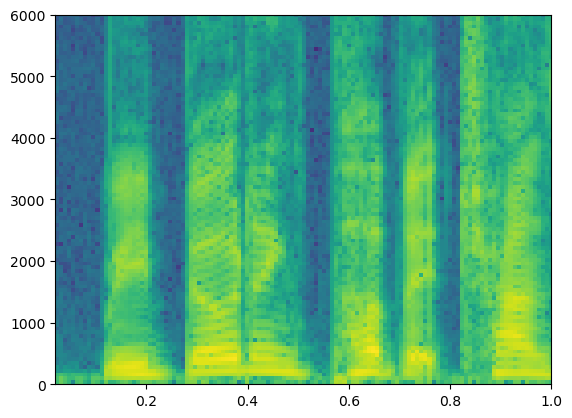

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
arr, extent = specgram(wav.squeeze().cpu(), sr=sr)
image = ax.imshow(
    arr,
    extent=extent,
    aspect="auto"
)
ax.set_xlim([0.02, 1])
ax.set_ylim([0, 6000]);

In [49]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )

    feats[0, :, zero_rows] = 0

with torch.inference_mode():
    wav_hat = hifigan(feats).squeeze(0)

In [50]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

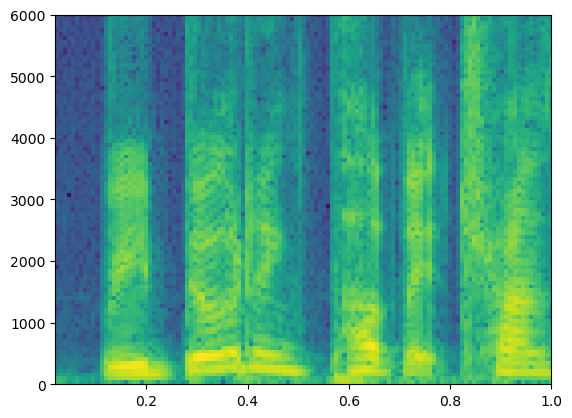

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
arr, extent = specgram(wav_hat.squeeze().cpu(), sr=sr)
image = ax.imshow(
    arr,
    extent=extent,
    aspect="auto"
)
ax.set_xlim([0.02, 1])
ax.set_ylim([0, 6000]);

## LinearVC on 256-dimensional WavLM

In [6]:
features_dir = Path("/home/kamperh/scratch/vctk/wavlm_256/")
wav_dir = Path("/home/kamperh/scratch/vctk/wav/")
source = "p279"
# source = "p225"
target = "p282"
# target = "p287"

In [7]:
pca_fn = Path("../data/wavlm_pca_256.npz")
pca = np.load(pca_fn)
pca_feats = {}
for key in ["mean", "components", "explained_variance"]:
    pca_feats[key] = torch.from_numpy(pca[key]).float().to(device)

In [8]:
source_feats_all = np.load((features_dir / source).with_suffix(".npy"))
target_feats_all = np.load((features_dir / target).with_suffix(".npy"))

In [25]:
k_top = 1
n_frames = 8192

source_feats = (
    torch.from_numpy(source_feats_all[:n_frames, :]).float().to(device)
)
target_feats = (
    torch.from_numpy(target_feats_all[:n_frames, :]).float().to(device)
)

dists = fast_cosine_dist(source_feats.squeeze(), target_feats, device=device)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

# W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())
linear = celer.Lasso(alpha=0.05, fit_intercept=False).fit(
# linear = celer.Lasso(alpha=5.0, fit_intercept=False).fit(
    source_feats.squeeze().cpu(), linear_target.cpu()
)
W = linear.coef_.T

W = torch.from_numpy(W).float().to(device)

In [26]:
wav_fn = wav_dir / source / f"{source}_057.wav"
# wav_fn = wav_dir / source / f"{source}_051.wav"
wav, _ = torchaudio.load(wav_fn)
wav = wav.to(device)
display.Audio(wav.squeeze().cpu(), rate=16000)

In [27]:
with torch.inference_mode():
    feats, _ = wavlm.extract_features(
        wav, output_layer=6
    )
feats_z = pca_transform(
    feats, pca_feats["mean"], pca_feats["components"],
    pca_feats["explained_variance"]
)    
source_to_target_feats_z = feats_z @ W
source_to_target_feats = pca_inverse_transform(
    source_to_target_feats_z, pca_feats["mean"], pca_feats["components"],
    pca_feats["explained_variance"]
)

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [28]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

Text(0.5, 1.0, '$W^{T}$')

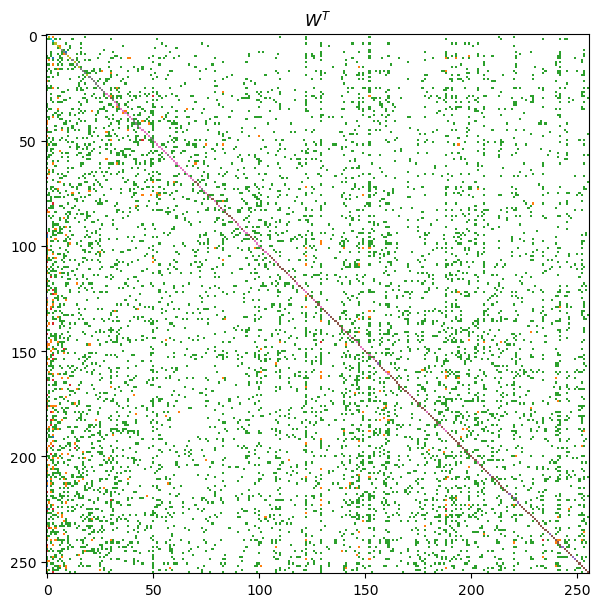

In [29]:
W_numpy = W.cpu().numpy()
matrix = W_numpy.copy()
matrix[matrix == 0.0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(matrix.T, interpolation="none", aspect="auto", cmap="tab10")
ax.set_title("$W^{T}$")

In [14]:
print(
    "Proportion zero: {:.2f}%".format(
        np.count_nonzero(W_numpy == 0) / W_numpy.shape[0] ** 2 * 100
    )
)
print("Determinant:", linalg.det(W_numpy))


Proportion zero: 98.08%
Determinant: 0.0


## Analysis of lasso matrices on LibriSpeech

These matrices where obtained using [experiments_libri.ipynb](../experiments_libri.ipynb) and are just loaded here.

In [6]:
projmat_dir = Path("/home/kamperh/scratch/linearvc/dev-clean/2024-11-12_lasso0.3/projmats")

In [7]:
projmats = {}
for npy_fn in tqdm(sorted(projmat_dir.glob("*.npy"))):
    projmats[npy_fn.stem] = np.load(npy_fn)

  0%|          | 0/1560 [00:00<?, ?it/s]

In [119]:
# npz_fn = Path("/home/kamperh/scratch/linearvc/dev-clean/2024-11-12_lasso3.0/projmats_8192.npz")
# print("Reading:", npz_fn)
# projmats = np.load(npz_fn)

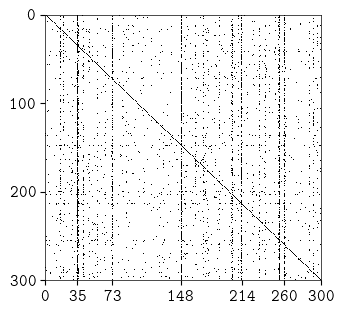

In [9]:
# Figure for paper
columnwidth_in = 3.1614172222244096844*0.7
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.08,
        "figure.subplot.left": 0.12,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.97,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

matrix = projmats["1272-1462"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
fig, ax = plt.subplots(1, 1, figsize=(columnwidth_in, columnwidth_in * 0.9))
ax.imshow(matrix.T, cmap="binary", aspect="auto", interpolation="none")

ax.set_xticks([0, 35, 73, 148, 214, 260, 300])
# ax.set_xticks([0, 35, 100, 148, 200, 260, 300, 400, 500])
ax.set_yticks([0, 100, 200, 300, 400, 500])
ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))

In [10]:
norms = []
for projmat in tqdm(projmats.values()):
    # np.fill_diagonal(projmat, 0)
    norm = np.linalg.norm(projmat, axis=1)
    norms.append(norm)
norms = np.mean(norms, axis=0)

  0%|          | 0/1560 [00:00<?, ?it/s]

In [11]:
np.where(norms > 0.5)

(array([  17,   20,   35,   36,   42,   47,   57,   73,  137,  148,  165,
         172,  178,  190,  200,  204,  210,  214,  233,  240,  244,  255,
         260,  288,  292,  300,  302,  305,  319,  323,  326,  336,  376,
         387,  415,  426,  453,  495,  510,  517,  545,  583,  590,  640,
         710,  713,  717,  724,  738,  774,  812,  827,  836,  852,  862,
         869,  908,  913,  916,  926,  927,  945,  955,  959,  972,  977,
        1011]),)

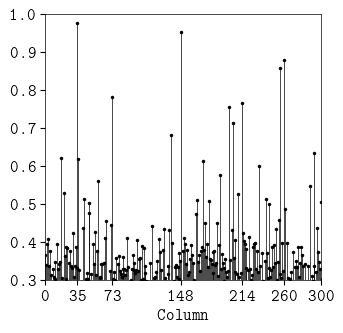

In [12]:
plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.08,
        "figure.subplot.left": 0.12,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.97,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

fig, ax = plt.subplots(1, 1, figsize=(columnwidth_in, columnwidth_in * 0.9))

markerline, stemlines, baseline = ax.stem(
    np.arange(len(norms)), norms, markerfmt=".", linefmt="k-", basefmt=" "
)
plt.setp(stemlines, 'linewidth', 0.5)

ax.set_xticks([0, 35, 73, 148, 214, 260, 300])
ax.set_xlim([0, 300])
ax.set_ylim([0.3, 1.0])
ax.set_xlabel("Column")
# ax.set_ylabel("Average norm")

from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

plt.savefig("lasso_norms.pdf")

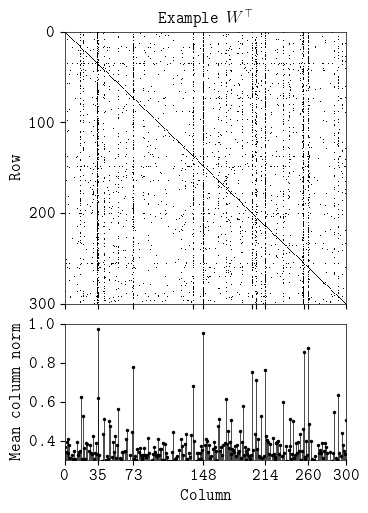

In [13]:
# Figure for paper
columnwidth_in = 3.1614172222244096844*0.75
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.09,
        "figure.subplot.left": 0.16,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.95,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.titlesize": "medium",
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

fig, ax = plt.subplots(
    2, 1, figsize=(columnwidth_in, columnwidth_in * 1.4), gridspec_kw={'height_ratios': [2, 1]}
)

matrix = projmats["1272-1462"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[0].imshow(matrix.T, cmap="binary", aspect="auto", interpolation="none")

ax[0].set_xticks([0, 35, 137, 73, 148, 200, 204, 214, 255, 260, 300])
ax[0].tick_params(labelbottom=False)  
# ax[0].set_xticks([0, 35, 100, 148, 200, 260, 300, 400, 500])
ax[0].set_yticks([0, 100, 200, 300, 400, 500])
ax[0].set_xlim([0, 300])
ax[0].set_ylim([300, 0])
ax[0].set_ylabel("Row")
ax[0].set_title(r"Example $W^\top$")

from matplotlib.ticker import FormatStrFormatter
ax[0].xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax[0].yaxis.set_major_formatter(FormatStrFormatter("%d"))


markerline, stemlines, baseline = ax[1].stem(
    np.arange(len(norms)), norms, markerfmt=".", linefmt="k-", basefmt=" "
)
plt.setp(stemlines, 'linewidth', 0.5)

ax[1].set_xticks([0, 35, 73, 148, 214, 260, 300])
ax[1].set_xlim([0, 300])
ax[1].set_ylim([0.3, 1.0])
ax[1].set_xlabel("Column")
ax[1].set_ylabel("Mean column norm")

ax[1].xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax[1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

plt.subplots_adjust(hspace=0.10)

plt.savefig("lasso_norms.pdf")

## Analysis of bias vectors

In [18]:
bias_fn = Path("/home/kamperh/scratch/linearvc/dev-clean/2024-12-04_additive/projmats.npz")

print("Reading:", bias_fn)
biases = np.load(bias_fn)

tmp = []
for key in biases:
    tmp.append(biases[key])
biases = tmp
biases = np.vstack(biases)

Reading: /home/kamperh/scratch/linearvc/dev-clean/2024-12-04_additive/projmats.npz


In [25]:
abs_mean = np.mean(np.abs(biases), axis=0)

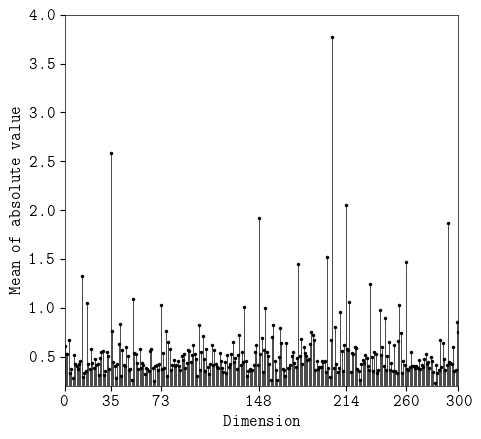

In [36]:
plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.10,
        "figure.subplot.left": 0.12,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.97,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

fig, ax = plt.subplots(1, 1, figsize=(columnwidth_in, columnwidth_in * 0.9))

markerline, stemlines, baseline = ax.stem(
    np.arange(len(abs_mean)), abs_mean, markerfmt=".", linefmt="k-", basefmt=" "
)
plt.setp(stemlines, 'linewidth', 0.5)

ax.set_xticks([0, 35, 73, 148, 214, 260, 300])
ax.set_xlim([0, 300])
ax.set_ylim([0.2, 4.0])
ax.set_xlabel("Dimension")
ax.set_ylabel("Mean of absolute value")

from matplotlib.ticker import FormatStrFormatter
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

plt.savefig("bias_norms.pdf")

## Analysis of lasso matrices on VTCK

These matrices where obtained using [experiments_vctk.ipynb](../experiments_vctk.ipynb) and are just loaded here.

In [8]:
npy_fns = [
    "p234-p237_008.npy",
    "p234-p237_023.npy",
    "p234-p241_008.npy",
    "p247-p249_008.npy",
]
projmats = {}
for npy_fn in npy_fns:
    projmats[Path(npy_fn).stem] = np.load(npy_fn)

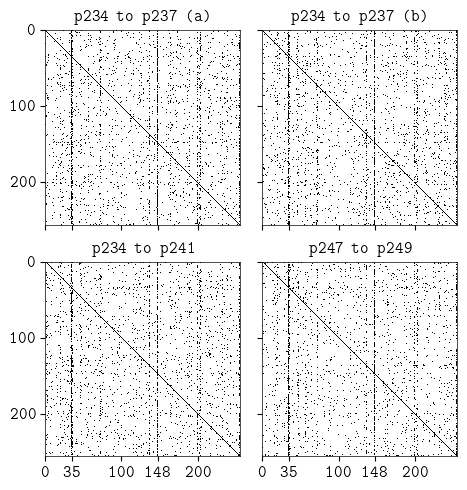

In [123]:
# Figure for paper
columnwidth_in = 3.1614172222244096844
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.05,
        "figure.subplot.left": 0.08,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.95,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.titlesize": "medium",
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

fig, ax = plt.subplots(
    2,
    2,
    figsize=(columnwidth_in, columnwidth_in),
    sharex=True,
    sharey=True
)

a = "equal"
matrix = projmats["p234-p237_023"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[0, 0].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[0, 0].set_title(r"p234 to p237 (a)")

matrix = projmats["p234-p237_008"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[0, 1].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[0, 1].set_title(r"p234 to p237 (b)")

matrix = projmats["p234-p241_008"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[1, 0].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[1, 0].set_title(r"p234 to p241")

matrix = projmats["p247-p249_008"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[1, 1].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[1, 1].set_title(r"p247 to p249")

# ax[1, 1].set_xticks([0, 35, 73, 148, 214, 260, 300])
ax[1, 1].set_xticks([0, 35, 100, 148, 200])
ax[1, 1].set_xlim([0, 256])
ax[1, 1].set_ylim([256, 0])

ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax[1, 1].yaxis.set_major_formatter(FormatStrFormatter("%d"))


plt.subplots_adjust(hspace=0.19, wspace=0.11)

# plt.tight_layout()
plt.savefig("lasso_projmats.pdf")

## Analysis of lasso matrices on LibriSpeech

In [7]:
projmat_dir = Path("/home/kamperh/scratch/linearvc/dev-clean/2024-11-12_lasso0.3/projmats")

In [8]:
npy_fns = [
    "1272-1462.npy",
    "1272-1462b.npy",
    "1272-1673.npy",
    "8842-8297.npy",
]
projmats = {}
for npy_fn in npy_fns:
    npy_fn = projmat_dir / npy_fn
    projmats[Path(npy_fn).stem] = np.load(npy_fn)

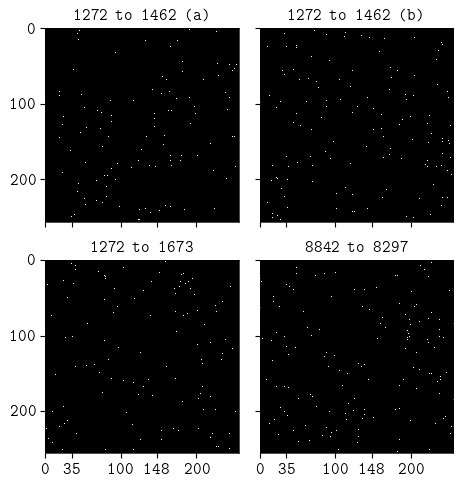

In [8]:
# Figure for paper
columnwidth_in = 3.1614172222244096844
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.05,
        "figure.subplot.left": 0.09,
        "figure.subplot.right": 0.95,
        "figure.subplot.top": 0.95,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.titlesize": "medium",
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

fig, ax = plt.subplots(
    2,
    2,
    figsize=(columnwidth_in, columnwidth_in),
    sharex=True,
    sharey=True
)

a = "equal"
matrix = projmats["1272-1462"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[0, 0].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[0, 0].set_title(r"1272 to 1462 (a)")

matrix = projmats["1272-1462b"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[0, 1].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[0, 1].set_title(r"1272 to 1462 (b)")

matrix = projmats["1272-1673"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[1, 0].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[1, 0].set_title(r"1272 to 1673")

matrix = projmats["8842-8297"].copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
ax[1, 1].imshow(matrix.T, cmap="binary", aspect=a, interpolation="none")
ax[1, 1].set_title(r"8842 to 8297")

# ax[1, 1].set_xticks([0, 35, 73, 148, 214, 260, 300])
ax[1, 1].set_xticks([0, 35, 100, 148, 200])
ax[1, 1].set_xlim([0, 256])
ax[1, 1].set_ylim([256, 0])

ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax[1, 1].yaxis.set_major_formatter(FormatStrFormatter("%d"))


plt.subplots_adjust(hspace=0.19, wspace=0.11)

# plt.tight_layout()
plt.savefig("lasso_projmats_librispeech.pdf")

## Analysis of unconstrained matrices on LibriSpeech

In [4]:
npy_fns = [
    "W_1272-1462.npy",
    "W_1272-1462b.npy",
    "W_1272-1673.npy",
    "W_8842-8297.npy",
]
projmats = {}
for npy_fn in npy_fns:
    npy_fn = npy_fn
    projmats[Path(npy_fn).stem[2:]] = np.load(npy_fn)

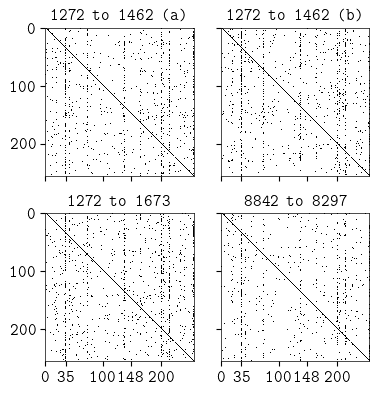

In [17]:
# Figure for paper
columnwidth_in = 3.1614172222244096844 * 0.8
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.06,
        "figure.subplot.left": 0.10,
        "figure.subplot.right": 0.98,
        "figure.subplot.top": 0.94,
        "font.family": "monospace",
        "font.serif": "Computer Modern Roman",
        "font.sans-serif": "Computer Modern Sans serif",
        "font.size": 12,
        "legend.fontsize": "medium",
        "text.usetex": True,
        "axes.titlesize": "medium",
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": True,
    }
)

fig, ax = plt.subplots(
    2,
    2,
    figsize=(columnwidth_in, columnwidth_in),
    sharex=True,
    sharey=True
)

a = "equal"
threshold = 0.06

matrix = projmats["1272-1462"].copy()
matrix[np.abs(matrix) < threshold] = 0.0
matrix[np.abs(matrix) > threshold] = 1.0
ax[0, 0].imshow(matrix, cmap="binary", aspect=a, interpolation="none")
ax[0, 0].set_title(r"1272 to 1462 (a)")

matrix = projmats["1272-1462b"].copy()
matrix[np.abs(matrix) < threshold] = 0.0
matrix[np.abs(matrix) > threshold] = 1.0
ax[0, 1].imshow(matrix, cmap="binary", aspect=a, interpolation="none")
ax[0, 1].set_title(r"1272 to 1462 (b)")

matrix = projmats["1272-1673"].copy()
matrix[np.abs(matrix) < threshold] = 0.0
matrix[np.abs(matrix) > threshold] = 1.0
ax[1, 0].imshow(matrix, cmap="binary", aspect=a, interpolation="none")
ax[1, 0].set_title(r"1272 to 1673")

matrix = projmats["8842-8297"].copy()
matrix[np.abs(matrix) < threshold] = 0.0
matrix[np.abs(matrix) > threshold] = 1.0
ax[1, 1].imshow(matrix, cmap="binary", aspect=a, interpolation="none")
ax[1, 1].set_title(r"8842 to 8297")

# ax[1, 1].set_xticks([0, 35, 73, 148, 214, 260, 300])
ax[1, 1].set_xticks([0, 35, 100, 148, 200])
ax[1, 1].set_xlim([0, 256])
ax[1, 1].set_ylim([256, 0])

ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax[1, 1].yaxis.set_major_formatter(FormatStrFormatter("%d"))


plt.subplots_adjust(hspace=0.25, wspace=0.11)

# plt.tight_layout()
plt.savefig("linear_projmats_librispeech.pdf")